In [1]:
from hazm import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import sklearn
import re
from tqdm import tqdm
from hazm.utils import stopwords_list
from sklearn.metrics import classification_report
from itertools import combinations

# دریافت فایل داده‌ها و ایجاد دیتافریم از آنها

In [2]:
snappfood = pd.read_csv(
    "datasets\\Snapfood\\Snappfood - Sentiment Analysis.csv",
    encoding="utf-8",
    on_bad_lines="skip",
    sep="\t")
snappfood = snappfood.drop('Unnamed: 0', axis=1)
snappfood.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0


# تقسیم داده ها
ابتدا ۲۰درصد از داده‌ها را جدا کرده و سپس ۱۰ درصد از این ۲۰ درصد را به عنوان داده تست در نظر گرفته‌ام

In [3]:
train_ds, _= train_test_split(snappfood, test_size=0.8)
train_ds, test_ds = train_test_split(train_ds, test_size=0.1)

# بررسی آماری توزیع داده‌ها
برای اطمینان از یکسان بودن توزیع برچسب‌ها نمودار هیستوگرام داده ها آموزش و تست را رسم کردم

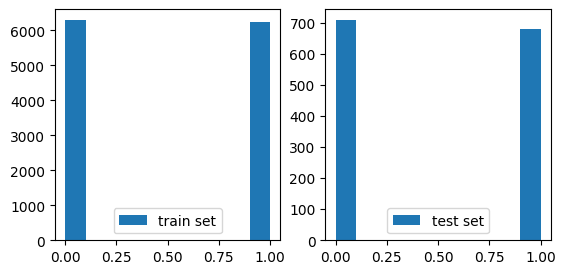

In [6]:
fig, axes = plt.subplots(ncols=2)
fig.set_figheight(3)
axes[0].hist(train_ds["label_id"], label="train set")
axes[1].hist(test_ds['label_id'], label="test set")
axes[0].legend()
axes[1].legend()

# پیش پردازش
- در قسمت پیش پردازش ابتدا حروف تکراری پست سر هم را به یک عدد کاهش دادم. به طور مثال در عبارت خیییییییلی به خیلی تبدیل می‌شود.
- در مرحله بعد با استفاده از کتابخانه هضم داده‌ها را نرمال کرده ام
- سپس تابع پیش پردازش را روی داده‌ها اعمال کردم

In [19]:
def preprocces(text):
  regex = r'(\w)\1{2,}'
  text = re.sub(regex, r"\1", text, 0, re.MULTILINE)
  text = Normalizer().normalize(text)
  return text

train_ds["proccessed"] = train_ds['comment'].apply(preprocces)
train_ds["tokens"] = train_ds['proccessed'].apply(WordTokenizer().tokenize)

test_ds["proccessed"] = test_ds['comment'].apply(preprocces)
test_ds["tokens"] = test_ds['proccessed'].apply(WordTokenizer().tokenize)

# نمونه‌های پیش پردازش شده از داده‌ها

In [21]:
for id in np.random.choice(train_ds.index, 50):
  print(train_ds.loc[id]['comment'])
  print(train_ds.loc[id]['proccessed'])
  print('-----------------------------')

بسیار بسیار بسیار کیفیت پایین داشت غذا بسته بندی وحشتناک بد بود غذا کاملا یخ زده بود خیلی خیلی ناراضی هستم از این غذایی که سفارش دادم
بسیار بسیار بسیار کیفیت پایین داشت غذا بسته بندی وحشتناک بد بود غذا کاملا یخ زده بود خیلی خیلی ناراضی هستم از این غذایی که سفارش دادم
-----------------------------
کباب لاستیک نپخته برنج کاه خارجی!
کباب لاستیک نپخته برنج کاه خارجی!
-----------------------------
سوسی کهنه و سفت بود
سوسی کهنه و سفت بود
-----------------------------
چیلی فرایز کاملا مزه کره میداد و خیلی تو ذوق میزد چیکن برگر سیاه شده بود فقط همبر‌گر خوب بود
چیلی فرایز کاملا مزه کره میداد و خیلی تو ذوق میزد چیکن برگر سیاه شده بود فقط همبر‌گر خوب بود
-----------------------------
اصلا شبیه تصویر نبود و نوتلا‌های روی کیک سر خرده بود ریخته بود نه جعبه
اصلا شبیه تصویر نبود و نوتلا‌های روی کیک سر خرده بود ریخته بود نه جعبه
-----------------------------
خوشمزه بود اما چیپسش بی نهایت زیاد بود
خوشمزه بود اما چیپسش بی نهایت زیاد بود
-----------------------------
وضعیت ارسال افتضاح بود، غذا کاملا یخ ک

# ساخت ماتریس فراونی لغات
به ازاء لغات غیر از لغات توقف یک بردار به طول تعداد داده‌ها درست کردم و تعداد تکرار هر لغت در آن متن را در درایه متناظر محاسبه کردم. به این ترتیب ماتریس فراوانی لغات بدست می‌آید.

In [127]:
vocabs_tf={}
for id, doc in tqdm(enumerate(train_ds['tokens'])):
    for t in doc:
        if t not in stopwords_list():
            if t not in vocabs_tf:
                vocabs_tf[t] = np.array([0]*len(train_ds['proccessed']))
            vocabs_tf[t][id] += 1

12600it [08:23, 25.04it/s]


# ماتریس فراوانی داکیومنت‌ها
به ازاء هر لغت تعداد داکیومنت‌هایی که آن لغت در آنها تکرار شده است را بدست آوردم

In [131]:
vocabs_df ={}
for v in vocabs_tf:
    vocabs_df[v] = 0
for v in tqdm(vocabs_tf):
    vocabs_df[v] = sum([(int)(x>0) for x in vocabs_tf[v]])
    

100%|██████████| 12858/12858 [01:53<00:00, 113.75it/s]


# بردار tf-idf
برای هر لغت بردار tf-idf را ساختم

In [179]:
tfidf = dict()
N = len(train_ds)
for t in vocabs_tf:
    tfidf[t] = np.log(vocabs_tf[t]+1)/np.log(10) * np.log(N/vocabs_df[t])/np.log(10)

# تابع تبدیل متن به بردار tfidf


In [183]:
def tfidf_vectorizer(tokens):
    count = 0
    vec = []
    for t in tokens:
        if t in tfidf:
            count+=1
            if len(vec)>0:
                vec += tfidf[t]
            else:
                vec = np.copy(tfidf[t])
    vec = np.array(vec)
    if count != 0:
        vec = vec/count
    else:
        for t in tfidf:
            vec = np.array([0] * len(tfidf[t]))
            break
    return vec

اعمال تابع روی داده آموزش و تست

In [205]:
test_ds["vec"] = test_ds["tokens"].apply(tfidf_vectorizer)
train_ds["vec"] = train_ds["tokens"].apply(tfidf_vectorizer)

train_dss = train_ds.dropna()
test_dss = test_ds.dropna()

آموزش و تست مدل بیز ساده با استفاده از ویژگیهای tfidf

In [208]:
clf = GaussianNB()
clf.fit(np.array([np.array(x) for x in train_dss["vec"]]), train_dss["label_id"])
prd = clf.predict(np.array([np.array(x) for x in test_dss["vec"]]))

print(classification_report(test_dss["label_id"], prd))

              precision    recall  f1-score   support

         0.0       0.86      0.61      0.71       665
         1.0       0.72      0.91      0.80       723

    accuracy                           0.76      1388
   macro avg       0.79      0.76      0.76      1388
weighted avg       0.78      0.76      0.76      1388



# PPMI
به ازاء هر دو کلمه در یک متن، تعداد مجاورت آن دو کلمه یکی اضافه شده است و نهایتا تعداد مجاورت‌های دو به دوی کلمات بدست آمده است

In [214]:
coaccurance = dict()
for i in vocabs_tf:
    coaccurance[i] = dict()
    for j in vocabs_tf:
        coaccurance[i][j] = 0
for doc in tqdm(train_ds["tokens"]):
    for comb in  combinations(doc, 2):
        if comb[0] in vocabs_tf and comb[1] in vocabs_tf:
            coaccurance[comb[0]][comb[1]] += 1
            coaccurance[comb[1]][comb[0]] += 1


100%|██████████| 12600/12600 [00:04<00:00, 2893.10it/s]


سپس تعداد مشاهده هر کلمه نیز به تنهایی به صورت جداگانه محاسبه شده است

In [223]:
for i in tqdm(vocabs_tf):
    count = 0
    for j in vocabs_tf:
        count += coaccurance[i][j]
    coaccurance[i]["total"] = count

total = 0
coaccurance["total"] = dict()
for j in tqdm(vocabs_tf):
    count = 0
    for i in vocabs_tf:
        count += coaccurance[i][j]
    total += count
    coaccurance["total"][j] = count
coaccurance["total"]["total"] = total

100%|██████████| 12858/12858 [03:21<00:00, 63.87it/s]


In [232]:
for i in coaccurance:
    if coaccurance[i]["total"] == 0:
        print(i)

SAD
HAPY
زودرسید
یریع
نوشتش
ملات‌تر
ماکارون‌ها
وپرسرعت
یاشاسین


# PPMI matrix
در این مرحله با استفاده از تعداد تکرار با هم کلمات ماتریس
- PPMI
محاسبه شده است

In [238]:
ppmi = dict()
for i in tqdm(vocabs_tf):
    ppmi[i] = dict()
    for j in vocabs_tf:
        p_i_j = coaccurance[i][j] / coaccurance["total"]["total"]
        p_i = coaccurance[i]["total"] / coaccurance["total"]["total"]
        p_j= coaccurance["total"][j] / coaccurance["total"]["total"]
        ppmi[i][j] = 0
        if p_i != 0 and p_j != 0 and p_i_j !=0:
            ppmi[i][j] = max(np.log(p_i_j)-np.log(p_i)-np.log(p_j), 0)

100%|██████████| 12858/12858 [06:35<00:00, 32.55it/s]


بردار هر کلمه بر اساس مقادیر محاسبه شده بدست آمده است

In [239]:
ppmi_vec = dict()
for i in tqdm(vocabs_tf):
    ppmi_vec[i] = []
    for j in vocabs_tf:
        ppmi_vec[i].append(ppmi[i][j])

100%|██████████| 12858/12858 [02:37<00:00, 81.63it/s]


تابع تبدیل ppmi

In [242]:
def ppmi_vectorizer(tokens):
    count = 0
    vec = []
    for t in tokens:
        if t in ppmi_vec:
            count+=1
            if len(vec)>0:
                vec += ppmi_vec[t]
            else:
                vec = np.copy(ppmi_vec[t])
    vec = np.array(vec)
    if count != 0:
        vec = vec/count
    else:
        for t in ppmi_vec:
            vec = np.array([0] * len(ppmi_vec[t]))
            break
    return vec

اعمال تابع روی داده‌ها

In [ ]:
test_dss["ppmi_vec"] = test_dss["tokens"].apply(ppmi_vectorizer)
train_dss["ppmi_vec"] = train_dss["tokens"].apply(ppmi_vectorizer)

آموزش و تست مدل

In [244]:
clf = GaussianNB()
clf.fit(np.array([np.array(x) for x in train_dss["ppmi_vec"]]), train_dss["label_id"])
prd = clf.predict(np.array([np.array(x) for x in test_dss["ppmi_vec"]]))

print(classification_report(test_dss["label_id"], prd))

              precision    recall  f1-score   support

         0.0       0.87      0.59      0.70       665
         1.0       0.71      0.92      0.80       723

    accuracy                           0.76      1388
   macro avg       0.79      0.75      0.75      1388
weighted avg       0.79      0.76      0.75      1388

